In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as sco
import numpy_linalg as la

In [2]:
import sl_py_tools.matplotlib_tricks as mplt
import sl_py_tools.numpy_tricks.markov as ma
import sl_py_tools.numpy_tricks.markov_param as mp

In [3]:
import complex_synapse as cs

In [4]:
from sl_py_tools.import_tricks import reload

In [5]:
np.set_printoptions(precision=3, suppress=True)

In [34]:
%pdoc plt.box

In [26]:
reload(cs)
reload(mp)

Reloading complex_synapse.synapse_memory_model
Reloading sl_py_tools.numpy_tricks
Reloading complex_synapse.synapse_base
Reloading complex_synapse.builders
Reloading complex_synapse.synapse_opt
Reloading complex_synapse.optimise
Reloading sl_py_tools.iter_tricks
Reloading sl_py_tools.arg_tricks
Reloading sl_py_tools.display_tricks
Reloading sl_py_tools.containers
Reloading sl_py_tools.range_tricks
Reloading sl_py_tools.abc_tricks
Reloading sl_py_tools.slice_tricks
Reloading sl_py_tools.numpy_tricks.markov
Reloading sl_py_tools.numpy_tricks
Reloading sl_py_tools.numpy_tricks.logic


In [3]:
serial = cs.SynapseMemoryModel.build(cs.builders.build_serial, 12, jmp=0.7)
cascade = cs.SynapseMemoryModel.build(cs.builders.build_cascade, 12, jmp=0.7)

In [4]:
t = la.geomspace(0.1, 1e4, 50)
serial_snr = serial.snr_exp_ave(t)
cascade_snr = cascade.snr_exp_ave(t)

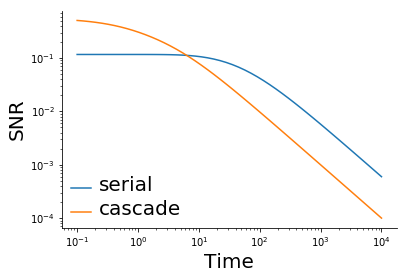

In [5]:
plt.loglog(t, serial_snr, label='serial')
plt.loglog(t, cascade_snr, label='cascade')
ax = plt.gca()
ax.set_xlabel("Time")
ax.set_ylabel("SNR")
lg = ax.legend(loc="lower left")
mplt.clean_axes(ax)

In [19]:
nst = 10
options = {'repeats': 10, 'method': 'trust-constr'}

In [20]:
s0 = 7
res = cs.optimise.optim_laplace(s0, nst, serial=True, **options)
res.success, res.message

(True, '`gtol` termination condition is satisfied.')

In [21]:
model = cs.SynapseOptModel.from_params(res.x, binary=True)
model.snr_laplace(7), model.laplace_grad(7)[0], res.fun

(0.12499975092575814, -0.12499975092575812, -0.12499975092575812)

In [28]:
s = la.geomspace(1e-4, 10, 50)
envelope_srl, models_srl = cs.optimise.optim_laplace_range(s, nst, serial=True, **options)
envelope_gen, models_gen = cs.optimise.optim_laplace_range(s, nst, serial=False, **options)

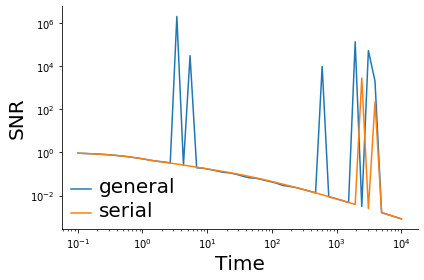

In [29]:
plt.loglog(1/s, envelope_gen * s, label='general')
plt.loglog(1/s, envelope_srl * s, label='serial')
ax = plt.gca()
ax.set_xlabel("Time")
ax.set_ylabel("SNR")
lg = ax.legend(loc="lower left")
mplt.clean_axes(ax)